# <font color='blue'>Projeto - Agrupando Clientes Por Consumo de Energia</font>

### Especificação

A partir de dados de consumo de energia de clientes, nosso trabalho é agrupar os consumidores por similaridade a afim de compreender o comportamento dos clientes e sua relação com o consumo de energia.

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from yellowbrick.cluster.elbow import kelbow_visualizer

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

C:\Users\Windows\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption

In [2]:
# Carregando os dados
df = pd.read_csv('household_power_consumption.txt', delimiter = ';', low_memory = False)

In [3]:
# Visualizando os dados
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [4]:
# Formato dos dados com linhas e colunas
df.shape

(2075259, 9)

In [5]:
# Obtendo uma amostra de 10% dos dados originais
amostra = df.sample(frac=0.1, random_state=11)

In [6]:
amostra.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
256294,12/6/2007,16:58:00,0.218,0.134,241.740,1.000,0.000,0.000,0.0
1024913,27/11/2008,11:17:00,1.354,0.000,240.880,5.600,0.000,0.000,18.0
417240,2/10/2007,11:24:00,2.104,0.054,235.360,9.000,0.000,14.000,17.0
1732129,2/4/2010,14:13:00,0.498,0.264,242.560,2.400,0.000,2.000,0.0
29880,6/1/2007,11:24:00,2.670,0.000,233.250,11.400,0.000,0.000,17.0


In [7]:
# Formato da amostra
amostra.shape

(207526, 9)

In [8]:
# Removendo colunas que não irei usar 
amostra1 = amostra.drop(['Date','Time'],axis = 1)

In [9]:
# Verificando quantidade de valores missing
amostra1.isna().sum()

Global_active_power         0
Global_reactive_power       0
Voltage                     0
Global_intensity            0
Sub_metering_1              0
Sub_metering_2              0
Sub_metering_3           2569
dtype: int64

In [10]:
# Removendo os valores missing
amostra1.dropna(inplace=True)

In [11]:
# Tipos de dados das variáveis
amostra.dtypes

Date                      object
Time                      object
Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1            object
Sub_metering_2            object
Sub_metering_3           float64
dtype: object

In [12]:
# Selecionando apenas as colunas do tipo object, pois quero convertê-las para o tipo numérico
cols = amostra1.select_dtypes('object').columns

In [13]:
# Fazendo a conversão
amostra1[cols] = amostra1[cols].astype(float)

In [14]:
# Checando o resultado, agora todas com tipo float
amostra1.dtypes

Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object

In [15]:
# Visualizando o novo dataset
amostra1.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
256294,0.218,0.134,241.74,1.0,0.0,0.0,0.0
1024913,1.354,0.000,240.88,5.6,0.0,0.0,18.0
417240,2.104,0.054,235.36,9.0,0.0,14.0,17.0
1732129,0.498,0.264,242.56,2.4,0.0,2.0,0.0
29880,2.670,0.000,233.25,11.4,0.0,0.0,17.0


In [16]:
# Informações estatísticas do dataset
amostra1.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,204957.000000,204957.000000,204957.000000,204957.000000,204957.000000,204957.000000,204957.000000
mean,1.092634,0.123713,240.845330,4.631757,1.113580,1.307138,6.461687
std,1.056875,0.112649,3.246142,4.442273,6.127724,5.839023,8.441557
min,0.076000,0.000000,224.480000,0.200000,0.000000,0.000000,0.000000
25%,0.310000,0.048000,238.990000,1.400000,0.000000,0.000000,0.000000
50%,0.604000,0.100000,241.010000,2.600000,0.000000,0.000000,1.000000
75%,1.530000,0.194000,242.890000,6.400000,0.000000,1.000000,17.000000
max,9.714000,1.080000,253.940000,42.600000,84.000000,79.000000,31.000000


In [17]:
# Mais informarções
amostra1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204957 entries, 256294 to 1909003
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Global_active_power    204957 non-null  float64
 1   Global_reactive_power  204957 non-null  float64
 2   Voltage                204957 non-null  float64
 3   Global_intensity       204957 non-null  float64
 4   Sub_metering_1         204957 non-null  float64
 5   Sub_metering_2         204957 non-null  float64
 6   Sub_metering_3         204957 non-null  float64
dtypes: float64(7)
memory usage: 12.5 MB


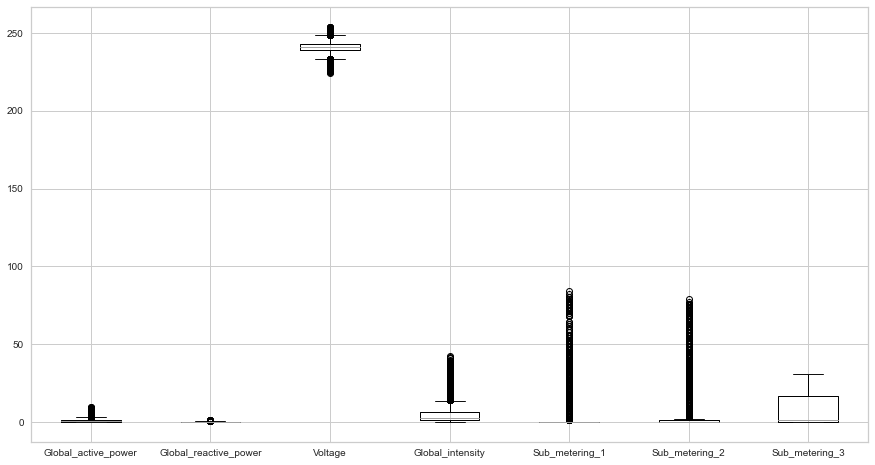

In [18]:
# Análise dos boxplots de todas as colunas
plt.figure(figsize=(15,8))
amostra1.boxplot()

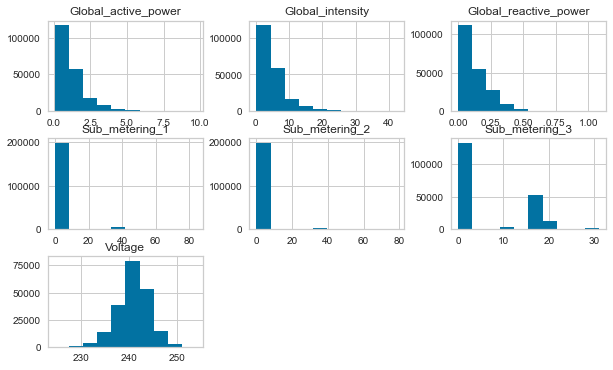

In [19]:
# Histograma
amostra1.hist(figsize=(10,6));

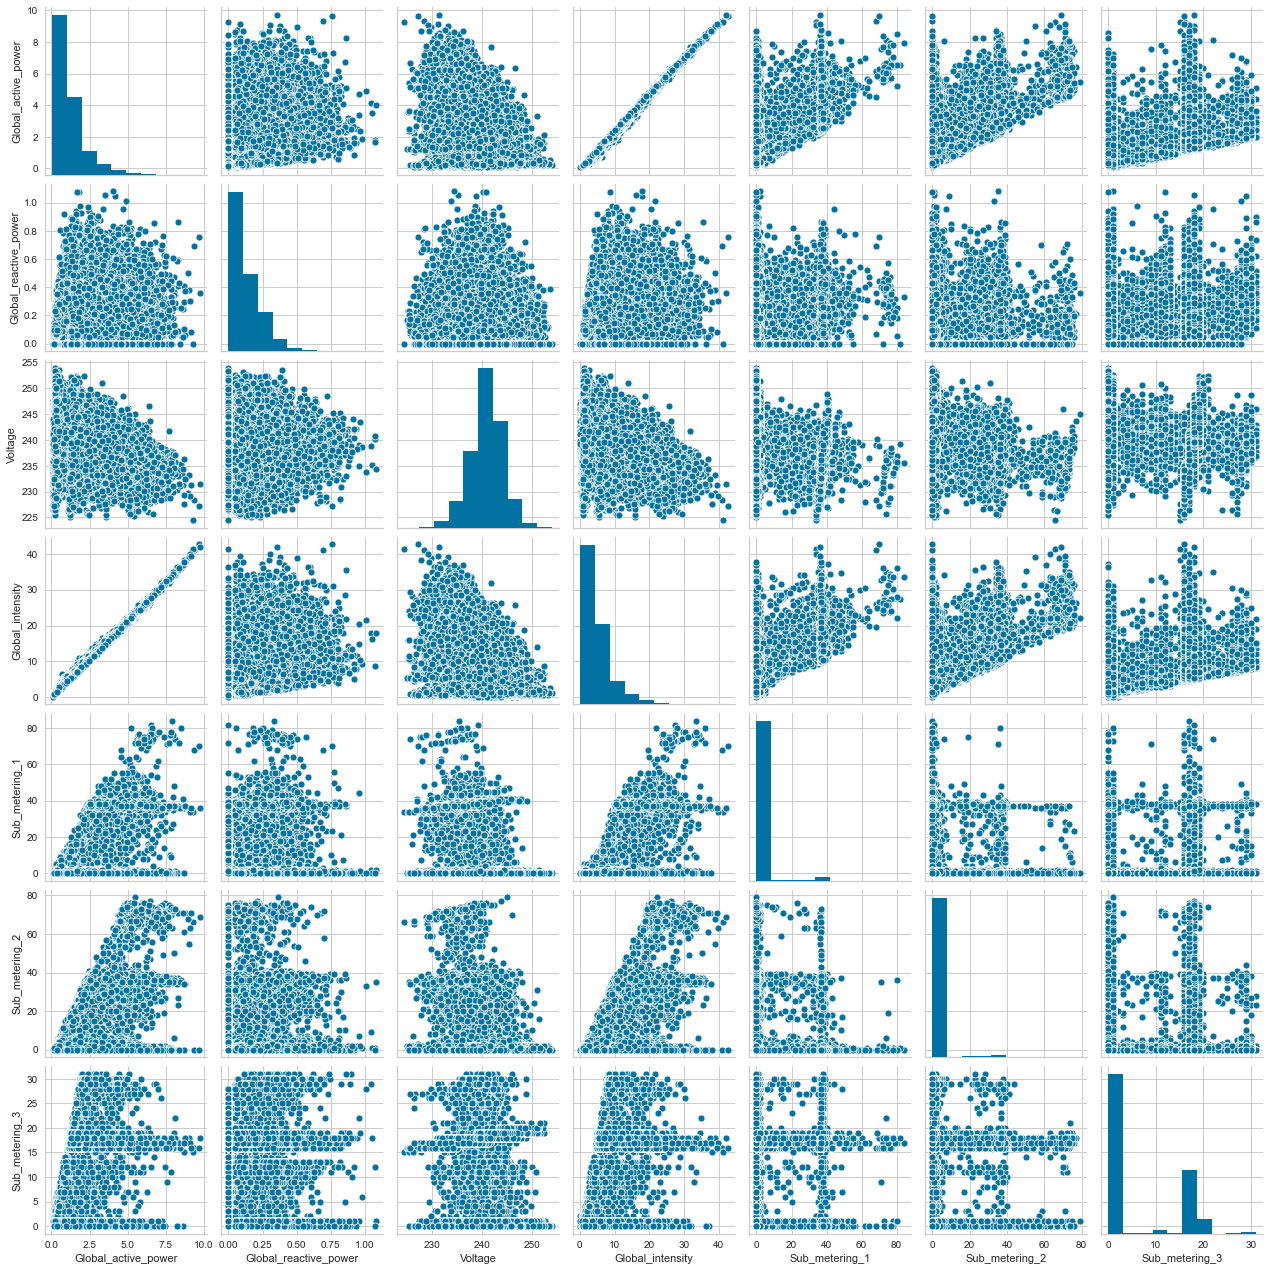

In [20]:
# Scatterplot Matrix, representando a correlação entre as variáveis
sns.pairplot(amostra1)

### Padronização

In [21]:
# Selecionando as features para o modelo KMeans
features = ['Voltage', 'Global_active_power', 'Global_reactive_power']

In [22]:
# Filtrando apenas as colunas selecionadas no dataframe e gravando em uma nova variavel
amostra2 = amostra1[features]

In [23]:
# Deixando na mesma escala - Padronização
scaled_sample = StandardScaler().fit_transform(amostra2)
scaled_sample = pd.DataFrame(scaled_sample,columns=amostra2.columns)

In [24]:
# Visualizando os dados na mesma escala
scaled_sample.head()

,Voltage,Global_active_power,Global_reactive_power
0,0.275611,-0.827569,0.091322
1,0.010680,0.247301,-1.098213
2,-1.689804,0.956942,-0.618848
3,0.528219,-0.562636,1.245348
4,-2.339808,1.492485,-1.098213


In [25]:
# Informações dos dados na nova escala
scaled_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204957 entries, 0 to 204956
Data columns (total 3 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Voltage                204957 non-null  float64
 1   Global_active_power    204957 non-null  float64
 2   Global_reactive_power  204957 non-null  float64
dtypes: float64(3)
memory usage: 4.7 MB


### Modelo K-Means 1

Usando as features padronizadas e sem aplicar o PCA

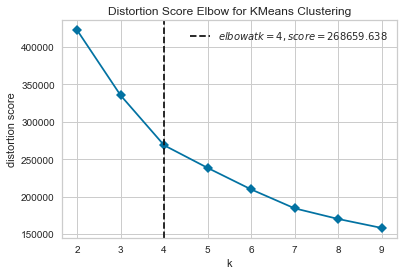

KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000002074ECE3828>,
                 k=None, model=None, timings=False)

In [26]:
# Instanciando o modelo e visualizando a quantidade ideal de clustes utilizando o método do cotovelo (elbow method)
model1 = KMeans()
kelbow_visualizer(model1, scaled_sample.values, k=(2,10), timings=False)

In [27]:
# A inércia do modelo é a diferença dos pontos de dados dentro do cluster para o centróide, elevado ao quadrado.
# Esssa distância quanto menor for melhor.
model1.inertia_

158179.66734597506

### Modelo K-Means 2

Usando as features padronizadas e aplicando o PCA

In [29]:
# Instanciando o PCA
pca = PCA(n_components=2)

# Aplicando o pca nos dados e salvando numa variável
components = pca.fit_transform(StandardScaler().fit_transform(amostra1))

# Criando um dataframe para melhor visualização
df_2d = pd.DataFrame({'Componente1':components[:,0], 'Componente2':components[:,1]})

# Visualizando
df_2d.head()

,Componente1,Componente2
0,-1.350641,0.369366
1,0.442645,-1.406541
2,2.422098,0.113926
3,-0.809547,1.341719
4,2.474832,-1.761512


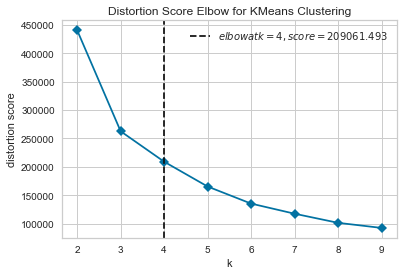

KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x000002074C2F7FD0>,
                 k=None, model=None, timings=False)

In [30]:
# Instanciando o modelo e visualizando a quantidade ideal de clustes utilizando o método do cotovelo (elbow method)
model2 = KMeans()
kelbow_visualizer(model2, df_2d.values, k=(2,10), timings=False)

In [31]:
# Inércia do modelo, quanto menor melhor
model2.inertia_

92424.60688536584

### Avaliando o modelo 1 com o pacote silhouette_score e através da visualização dos clusters

In [32]:
# Gravando as previsões em uma variável
model1 = KMeans(4)
pred1 = model1.fit_predict(scaled_sample)

In [33]:
# Atribuindo as previsões ao dataframe e visualizando
df_pred1 = scaled_sample.copy()
df_pred1['Labels'] = pred1
df_pred1.head()

,Voltage,Global_active_power,Global_reactive_power,Labels
0,0.275611,-0.827569,0.091322,0
1,0.010680,0.247301,-1.098213,1
2,-1.689804,0.956942,-0.618848,1
3,0.528219,-0.562636,1.245348,3
4,-2.339808,1.492485,-1.098213,1


In [35]:
# Para visualizar em um scatter plot, precisamos transformar as 3 variáveis explanatórias em 2 componentes com PCA
pca = PCA(2)
df_pred1 = pca.fit_transform(df_pred1.drop(columns='Labels'))
df_pred1 = pd.DataFrame(df_pred1, columns=['Componente1', 'Componente2'])

In [36]:
# Atribuindo as previsões e visualizando o dataframe
df_pred1['Labels']  = pred1
df_pred1.head()

,Componente1,Componente2,Labels
0,-0.676703,0.316074,0
1,-0.324418,-0.971982,1
2,1.385093,-1.481904,1
3,-0.146120,1.402532,3
4,1.923235,-2.280593,1


#### Calculo Silhouette
O melhor valor é 1 e o pior é -1, valores próximos a zero indicam sobreposição dos clusters.

In [37]:
# Calculate Silhoutte Score
score = silhouette_score(df_pred1.drop(columns='Labels').values, pred1, metric='euclidean')

# Print the score
print('Silhouetter Score: %.3f' % score)

Silhouetter Score: 0.338


Text(0.5, 1.0, 'KMeans com 4 clusters')

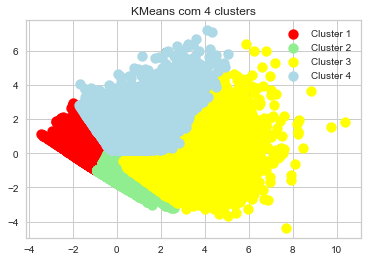

In [38]:
# Visualizando os clusters
plt.scatter(df_pred1.Componente1, df_pred1.Componente2, c=df_pred1.Labels);
plt.scatter(df_pred1.loc[df_pred1.Labels == 0, 'Componente1'], df_pred1.loc[df_pred1.Labels == 0, 'Componente2'], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(df_pred1.loc[df_pred1.Labels == 1, 'Componente1'], df_pred1.loc[df_pred1.Labels == 1, 'Componente2'], s = 100, c = 'lightgreen', label = 'Cluster 2')
plt.scatter(df_pred1.loc[df_pred1.Labels == 2, 'Componente1'], df_pred1.loc[df_pred1.Labels == 2, 'Componente2'], s = 100, c = 'yellow', label = 'Cluster 3')
plt.scatter(df_pred1.loc[df_pred1.Labels == 3, 'Componente1'], df_pred1.loc[df_pred1.Labels == 3, 'Componente2'], s = 100, c = 'lightblue', label = 'Cluster 4')

plt.legend()
plt.title("KMeans com 4 clusters")

### Avaliando o modelo 2 com o pacote silhouette_score e através da visualização dos clusters

In [39]:
# Visualizando o dataframe de 2 dimensões
df_2d.head()

,Componente1,Componente2
0,-1.350641,0.369366
1,0.442645,-1.406541
2,2.422098,0.113926
3,-0.809547,1.341719
4,2.474832,-1.761512


In [40]:
# Instanciando o modelo, fazendo as previsões e gravando em uma variável
model2 = KMeans(4)
pred2 = model2.fit_predict(df_2d.values)

In [41]:
# Gravando os resultado no dataframe e visualizando
df_pred2 = df_2d.copy()
df_pred2['Labels'] = pred2
df_pred2.head()

,Componente1,Componente2,Labels
0,-1.350641,0.369366,0
1,0.442645,-1.406541,1
2,2.422098,0.113926,1
3,-0.809547,1.341719,0
4,2.474832,-1.761512,1


In [42]:
# Calculando Silhoutte Score
score = silhouette_score(df_pred2.drop(columns='Labels').values, pred2, metric='euclidean')

# Print the score
print('Silhouetter Score: %.3f' % score)

Silhouetter Score: 0.558


Text(0.5, 1.0, 'KMeans com 4 clusters')

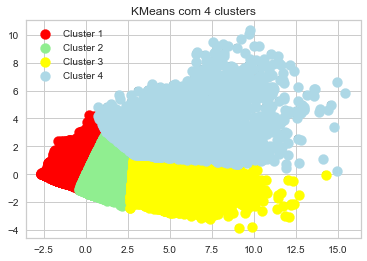

In [43]:
# Visualizando os clusters
plt.scatter(df_pred2.Componente1, df_pred2.Componente2, c=df_pred2.Labels);
plt.scatter(df_pred2.loc[df_pred2.Labels == 0, 'Componente1'], df_pred2.loc[df_pred2.Labels == 0, 'Componente2'], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(df_pred2.loc[df_pred2.Labels == 1, 'Componente1'], df_pred2.loc[df_pred2.Labels == 1, 'Componente2'], s = 100, c = 'lightgreen', label = 'Cluster 2')
plt.scatter(df_pred2.loc[df_pred2.Labels == 2, 'Componente1'], df_pred2.loc[df_pred2.Labels == 2, 'Componente2'], s = 100, c = 'yellow', label = 'Cluster 3')
plt.scatter(df_pred2.loc[df_pred2.Labels == 3, 'Componente1'], df_pred2.loc[df_pred2.Labels == 3, 'Componente2'], s = 100, c = 'lightblue', label = 'Cluster 4')

plt.legend()
plt.title("KMeans com 4 clusters")

# Atribuindo as labels no dataset original
#### Usando o modelo 2 feito com PCA
Calcular a média de consumo de energia por cluster (usar a coluna Global_active_power para o cálculo da média).

In [48]:
# Dataset original
amostra1.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Cluster
256294,0.218,0.134,241.74,1.0,0.0,0.0,0.0,0
1024913,1.354,0.000,240.88,5.6,0.0,0.0,18.0,1
417240,2.104,0.054,235.36,9.0,0.0,14.0,17.0,1
1732129,0.498,0.264,242.56,2.4,0.0,2.0,0.0,0
29880,2.670,0.000,233.25,11.4,0.0,0.0,17.0,1


In [49]:
# Criando a coluna com os clusters
amostra1['Cluster'] = pred2

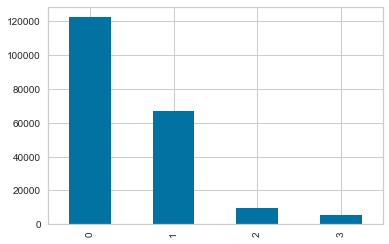

In [50]:
# Quantidade de observações por cluster
amostra1.Cluster.value_counts().plot(kind='bar')

In [51]:
# Média de consumo de energia por cluster
amostra1.groupby('Cluster')['Global_active_power'].mean()

Cluster
0    0.422075
1    1.716392
2    3.705282
3    3.725668
Name: Global_active_power, dtype: float64

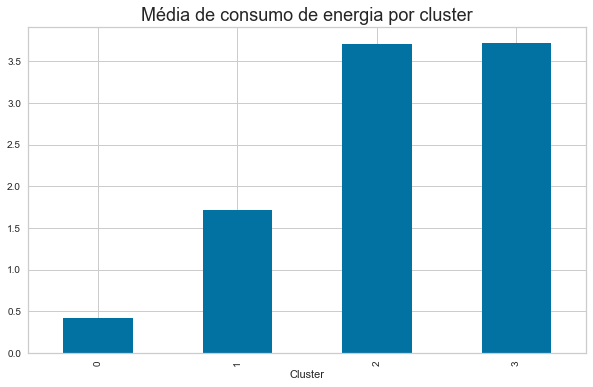

In [52]:
# Gráfico
plt.figure(figsize=(10,6))
amostra1.groupby('Cluster')['Global_active_power'].mean().plot(kind='bar')

plt.title("Média de consumo de energia por cluster", fontsize=18)
plt.show()

### Conclusão

Termino o projeto com o **modelo número 2**, onde foi feito o pré-processando padronizando as variáveis preditoras e em seguida reduzindo a dimensionalidade dele para 2 componentes usando o PCA, **este modelo foi o qual apresentou o melhor Silhouette Score (0.56)**, um pouco a mais do que o modelo 1. O modelo 1 não conseguiu fazer uma separação bem definida dos cluster (Silhouette Score próximo a 0), isso se deve ao nosso conjunto de dados, em nem todos os datasets é possível realizar o agrupamento.

Agora que temos os clusters definidos, podemos partir para uma análise mais aprofundada sobre cada grupo, saber qual a diferença dos clientes que estão em diferentes clusters.
**Com isso podemos tomar decisões diferentes para cada tipo de cliente, como por exemplo enviar um tipo de promoção/propaganda para um determinado cliente do cluster 1, e um outro tipo de propaganda/promoção para o cliente do cluster 4 por exemplo.**

# Fim



Obrigado,

Dener Moreira

*GitHub:* https://github.com/DenerBEM